<a href="https://colab.research.google.com/github/ColmTalbot/windowing-in-parameter-estimation/blob/main/notebooks/windowing_normalization_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gwpy gwosc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 89.4 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 24.2.1 requires cryptography<44,>=41.0.5, but you have cryptography 45.0.5 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 45.0.5 which is incompatible.


In [3]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended texlive-science

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-gfs-baskerville
  fonts-gfs-porson fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 ghostscript libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern pfb2t1c2pfb poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-lang-greek
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | f

In [2]:
!wget https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW150914_PSDs.dat

--2025-07-30 15:25:03--  https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW150914_PSDs.dat
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.133
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 312864 (306K)
Saving to: ‘GWTC1_GW150914_PSDs.dat’

GWTC1_GW150914_PSDs 100%[===================>] 305.53K  --.-KB/s    in 0.1s    

2025-07-30 15:25:04 (2.36 MB/s) - ‘GWTC1_GW150914_PSDs.dat’ saved [312864/312864]



In [4]:
import numpy as np
import matplotlib.pyplot as plt
from gwosc import datasets
from gwpy.timeseries import TimeSeries
from scipy.signal.windows import tukey
from scipy.stats import norm

import matplotlib as mpl

mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath} \usepackage{amssymb}"
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "cm"
mpl.rcParams["axes.grid"] = False
mpl.rcParams["font.size"] = 16

%matplotlib inline

In [5]:
trigger_time = datasets.event_gps("GW159014")
duration = 8
post_trigger_duration = 2
end_time = trigger_time + post_trigger_duration - duration
start_time = end_time - duration * 2

strain = TimeSeries.fetch_open_data("H1", start_time, end_time).highpass(12)

freqs, psd, _ = np.genfromtxt("GWTC1_GW150914_PSDs.dat").T
asd = np.interp(np.fft.rfftfreq(len(strain), 1 / 4096), freqs, psd**0.5)


roll_offs = [0.0, 0.2, 1.0]

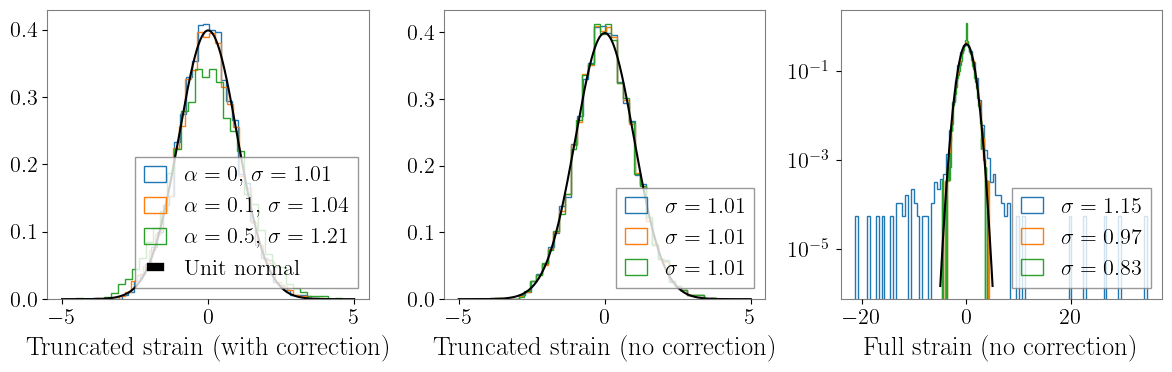

In [12]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=False)

time_domain_slice = slice(
    int(strain.sample_rate.value * 3),
    int(strain.sample_rate.value * 5),
)
frequency_domain_slice = slice(0, int(strain.duration.value * 1024))
normalization = (strain.duration.value / strain.sample_rate.value/ 8)**0.5

plt.sca(axes[0])
for alpha in [0, 0.1, 0.5]:
    truncated = (
        (strain * tukey(len(strain), alpha)).fft() / asd * normalization
    )[frequency_domain_slice].ifft().value[time_domain_slice]
    truncated /= np.mean(tukey(len(strain), alpha)**2)**0.5
    plt.hist(truncated, bins=40, density=True, histtype="step", label=f"$\\alpha = {alpha}$, $\\sigma = {np.std(truncated):.2f}$")
plt.plot(np.linspace(-5, 5, 1000), norm.pdf(np.linspace(-5, 5, 1000)), label="Unit normal", color="k")
plt.legend(loc="lower right")
plt.xlabel("Truncated strain (with correction)")

plt.sca(axes[1])
for alpha in [0, 0.1, 0.5]:
    truncated = (
        (strain * tukey(len(strain), alpha)).fft() / asd * normalization
    )[frequency_domain_slice].ifft().value[time_domain_slice]
    plt.hist(truncated, bins=40, density=True, histtype="step", label=f"$\\sigma = {np.std(truncated):.2f}$")
plt.plot(np.linspace(-5, 5, 1000), norm.pdf(np.linspace(-5, 5, 1000)), color="k")
plt.legend(loc="lower right")
plt.xlabel("Truncated strain (no correction)")

plt.sca(axes[2])
for alpha in [0, 0.1, 0.5]:
    truncated = (
        (strain * tukey(len(strain), alpha)).fft() / asd * normalization
    )[frequency_domain_slice].ifft().value
    plt.hist(truncated, bins=100, density=True, histtype="step", label=f"$\\sigma = {np.std(truncated):.2f}$")
plt.plot(np.linspace(-5, 5, 1000), norm.pdf(np.linspace(-5, 5, 1000)), color="k")
plt.legend(loc="lower right")
plt.xlabel("Full strain (no correction)")
plt.yscale("log")

plt.tight_layout()
plt.savefig("whitened_normalization_comp.png")
plt.show()
plt.close()